In [1]:
import itertools
import pandas as pd
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from tqdm import tqdm_notebook

TEST_SIZE = 150000

Using TensorFlow backend.


In [2]:
def load_data():
    df = pd.read_csv(
            "../input/train.csv",
            names=["x", "y"],
            skiprows=1,
            dtype={"x": "float32", "y": "float32"}
        )
    return df
BIG_FRAME = load_data()

In [3]:
def yield_case():
    data = BIG_FRAME.values
    max_start = len(data) - TEST_SIZE + 1
    while True:
        start = np.random.randint(max_start)
        end = start + TEST_SIZE
        if data[start, 1] < data[end - 1, 1]:
            continue  
        yield data[start:end, :1], data[end - 1, 1]

In [4]:
def yield_batch(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, TEST_SIZE, 1))
        y_batch = np.zeros((batch_size, ))
        gen = yield_case()
        for i, (x, y) in zip(range(batch_size), gen):
            x_batch[i] = x
            y_batch[i] = y
        yield x_batch, y_batch

In [5]:
def primes(num=TEST_SIZE):
    d = 2
    rez = []
    while num > 1:
        full, rem = divmod(num, d)
        if not rem:
            rez.append(d)
            num = full
        else:
            d += 1
    for i in sorted(rez, reverse=True):
        yield i

In [6]:
def make_model(filters):
    K.clear_session()
    y = x = layers.Input(shape=(TEST_SIZE, 1))
    
    # Pad at start
    y = layers.Lambda(
            lambda x: x[:, -1::-1, :], output_shape=(TEST_SIZE, 1))(y)
    
    y = layers.Conv1D(
            filters=filters,
            kernel_size=1,
            strides=1,
            activation=None)(y)
    
    skips = []
    for kernel_size in range(int(np.log(TEST_SIZE) / np.log(2)) + 1):
        y_rez = layers.AveragePooling1D(
            pool_size=1,
            strides=2,
            padding="same"
        )(y)
        y_f = layers.Conv1D(
            filters=filters,
            kernel_size=2,
            strides=2,
            padding="same",
            activation="tanh")(y)   # Try ReLu
        y_g = layers.Conv1D(
            filters=filters,
            kernel_size=2,
            strides=2,
            padding="same",
            activation="sigmoid")(y)
        y = layers.Multiply()([y_f, y_g])
        y_skip = layers.Conv1D(
            filters=filters,
            kernel_size=1,
            strides=1,
            activation=None)(y)
        y_skip = layers.Lambda(
            lambda x: x[:, -1:, :], output_shape=(1, filters))(y_skip)
        skips.append(y_skip)
        y = layers.Conv1D(
            filters=filters,
            kernel_size=1,
            strides=1,
            activation=None)(y)
        y = layers.Add()([y_rez, y])
        
    y = layers.Add()(skips)
    y = layers.Activation("relu")(y)
    y = layers.Conv1D(
            filters=filters,
            kernel_size=1,
            strides=1,
            activation="relu")(y)
    y = layers.Conv1D(
            filters=1,
            kernel_size=1,
            strides=1,
            activation="relu")(y)
    y = layers.Flatten()(y)

    model = models.Model(inputs=x, outputs=y)
    model.compile(optimizer=optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss='mean_absolute_error',
                  # metrics=['mean_absolute_error']
    )
    model.summary()
    return model

In [7]:
def train_model(filters, batch_size, epochs=100):
    model = make_model(filters)
    steps = 600 * 10 ** 6 // TEST_SIZE // batch_size
    cb = [
        callbacks.ModelCheckpoint("model_conv.h5", monitor="loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='loss', patience=epochs // 10, verbose=10)
    ]
    rez = model.fit_generator(
        yield_batch(batch_size),
        steps_per_epoch=steps,
        epochs=epochs,
        callbacks=cb
    )
    return rez

In [8]:
rez = train_model(128, 24)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 150000, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 150000, 128)  256         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 75000, 128)   32896       conv1d_1[0][0]                   
_____________________________________

In [9]:
# 2.12 - relu?

In [10]:
pd.DataFrame(rez.history)

,loss
0,2.844535
1,2.685416
2,2.506978
3,2.414309
4,2.327375
5,2.271727
6,2.279340
7,2.264768
8,2.215024
9,2.192257


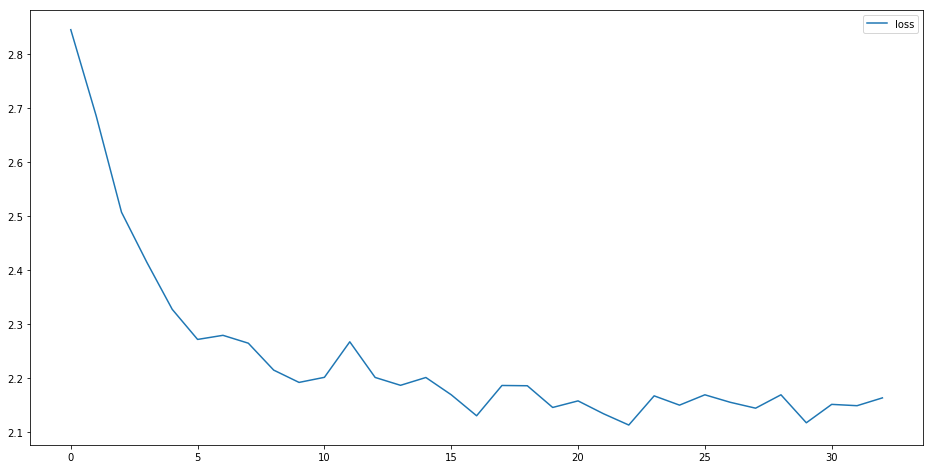

In [11]:
pd.DataFrame(rez.history).plot(figsize=(16, 8))

In [12]:
model = models.load_model("model_conv.h5")
submission = pd.read_csv(
    "../input/sample_submission.csv", 
    index_col='seg_id', 
    dtype={'time_to_failure': np.float32}
)
for seg_id in tqdm_notebook(submission.index):
    seg = pd.read_csv(f"../input/test/{seg_id}.csv")
    X = seg["acoustic_data"].values.reshape(1, TEST_SIZE, 1)
    y = model.predict(X)
    submission.loc[seg_id]["time_to_failure"] = y
submission.to_csv(f"submission.csv")